In [36]:
# %load improved_find_data_start_row\(file_path\).py
from openpyxl import load_workbook
import pandas as pd

def improved_find_data_start_row(file_path):
    """
    Improved version to find the data start row in an Excel file.
    This version scans the first sheet to find the likely start of the data based on a heuristic that considers
    both the number of non-empty cells in a row and the consistency of data types in the row.
    """
    workbook = load_workbook(filename=file_path, read_only=True)
    sheet = workbook.worksheets[0]  # Assuming data is in the first sheet
    
    min_filled_cells = 2  # Minimum number of non-empty cells to consider a row as potential data start
    likely_data_start_row = 0
    consecutive_data_like_rows = 0
    
    for i, row in enumerate(sheet.iter_rows(values_only=True)):
        # Count non-empty cells and types of data in the row
        non_empty_cells = [cell for cell in row if cell is not None]
        filled_cells = len(non_empty_cells)
        data_types = {type(cell) for cell in non_empty_cells}
        
        # Check for a row with enough filled cells and more than one type of data (mixed types suggest data row)
        if filled_cells >= min_filled_cells and len(data_types) > 1:
            consecutive_data_like_rows += 1
        else:
            consecutive_data_like_rows = 0  # Reset if the row doesn't seem like a data row
        
        # If we find 2 consecutive rows that look like data, it's likely the start of the data
        if consecutive_data_like_rows >= 2:
            likely_data_start_row = i - 2  # Adjusting for 0-based index and to include the first data-like row
            break
    
    return likely_data_start_row

def improved_load_excel_with_autodetect(file_path):
    """
    Load an Excel file into a pandas DataFrame, attempting to auto-detect the start of the actual data using
    an improved mechanism.
    """
    start_row = improved_find_data_start_row(file_path)
    df = pd.read_excel(file_path, sheet_name=0, skiprows=start_row)
    return df

def load_all_sheets_with_data_start_detection(file_path):
    """
    Load all sheets from an Excel workbook, applying an improved mechanism to detect
    the start of actual data in each sheet.
    
    :param file_path: Path to the Excel workbook.
    :return: A dictionary of DataFrames, one for each sheet, with data start auto-detected.
    """
    # Load all sheets into a dictionary of DataFrames
    all_sheets = pd.read_excel(file_path, sheet_name=None, header=None)
    
    # Apply the improved data start detection mechanism to each sheet
    for sheet_name, df in all_sheets.items():
        # Find the likely data start row using the improved mechanism
        start_row = improved_find_data_start_row(file_path)
        # Reload the sheet with detected start row, if there is meaningful data to skip
        if start_row > 0:
            all_sheets[sheet_name] = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=start_row)
    
    return all_sheets


In [37]:


def clean_cashflow_data(cashflow_data):
    # Replace a special character in the first column
    cashflow_data.iloc[:, 0] = cashflow_data.iloc[:, 0].str.replace('∟', '', regex=True)

    # Replace non-breaking space and 'n.a.' with NaN
    cashflow_data.replace('\xa0', '', regex=True, inplace=True)
    cashflow_data.replace('n.a.', np.nan, inplace=True)

    # Drop columns where all values are NaN
    cashflow_data = cashflow_data.dropna(how='all', axis=1)

    # Drop rows with less than 10 non-NaN values
    cashflow_data = cashflow_data.dropna(thresh=10)

    return cashflow_data


def update_column_names(cashflow_data, base_year):
    # Calculate the number of years by subtracting one to exclude the 'Cash Metric' column
    number_of_years = cashflow_data.shape[1] - 1
    
    # Create a list of years in reverse order starting from the base year
    years = [str(base_year - i) for i in range(number_of_years)]
    
    # Update DataFrame column names
    cashflow_data.columns = ['Cash Metric'] + years
    
    # Strip whitespace from the 'Cash Metric' column
    cashflow_data['Cash Metric'] = cashflow_data['Cash Metric'].str.strip()
    
    return cashflow_data






In [88]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# Import data into pandas DataFrame
# Assuming financial_data and store_counts are already loaded into pandas DataFrames
walmartPath="/Users/myself/Desktop/Walmart USA Serching for Growth/"



cashflow_data=pd.read_excel(walmartPath+"walmartCashFlow.xlsx",skiprows=15)

store_count=pd.read_excel(walmartPath+"walmartCashFlow.xlsx", "Yearly Store Count by Type",skiprows=2)
store_count.columns=store_count.columns.astype(str)

# cashflow_data,store_count
distribution_count=pd.read_excel(walmartPath+"walmartCashFlow.xlsx", "Yearly DC", skiprows=1)

cashflow_data.iloc[:,0]=cashflow_data.iloc[:,0].str.replace('∟', '', regex=True)

cashflow_data.replace('\xa0', '', regex=True, inplace=True)
cashflow_data.replace('n.a.', np.nan, inplace=True)

cashflow_data=cashflow_data.dropna(how='all',axis=1)
cashflow_data=cashflow_data.dropna(thresh=10)
cashflow_data


# Correctly identify and assign unique years to each financial data column
# Assuming the first column after 'Financial Metric' is the most recent year and decrement for each column after
number_of_years = cashflow_data.shape[1] - 1  # Total columns minus the 'Financial Metric' column
base_year = 2022
years = [str(base_year - i) for i in range(number_of_years)]

# # Map the new year labels to the columns
cashflow_data.columns = ['Cash Metric'] + years
cashflow_data['Cash Metric']=cashflow_data['Cash Metric'].str.strip()



statement_data=pd.read_excel(walmartPath+"walmartHistoricalFinancials.xlsx",skiprows=15)

statement_data = clean_cashflow_data(statement_data)
statement_data = update_column_names(statement_data,2021)

,Cash Metric,2021,2020,2019,2018,2017,2016,2015,2014,2013,...,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995
1,Non-current assets,1.624290e+08,1.746890e+08,1.573980e+08,1.448580e+08,1.411360e+08,1.393420e+08,1.402120e+08,1.435660e+08,1.431650e+08,...,7.098400e+07,6.408600e+07,5.564900e+07,51575000.0,45993000.0,28864000.0,26032000.0,21611000.0,20210000.0,17481000.0
2,Intangible assets,2.898300e+07,3.107300e+07,3.118100e+07,1.824200e+07,1.703700e+07,1.669500e+07,1.810200e+07,1.951000e+07,2.049700e+07,...,9.882000e+06,9.389000e+06,8.566000e+06,9059000.0,9392000.0,2538000.0,0.0,0.0,0.0,0.0
3,Tangible fixed assets,1.098480e+08,1.270490e+08,1.113950e+08,1.148180e+08,1.141780e+08,1.165160e+08,1.166550e+08,1.179070e+08,1.166810e+08,...,5.902300e+07,5.137400e+07,4.575000e+07,40934000.0,35969000.0,25973000.0,23606000.0,20324000.0,18894000.0,15874000.0
4,Other non-current assets,2.359800e+07,1.656700e+07,1.482200e+07,1.179800e+07,9.921000e+06,6.131000e+06,5.455000e+06,6.149000e+06,5.987000e+06,...,2.079000e+06,3.323000e+06,1.333000e+06,1582000.0,632000.0,353000.0,2426000.0,1287000.0,1316000.0,1607000.0
5,Current assets,9.006700e+07,6.180600e+07,6.189700e+07,5.966400e+07,5.768900e+07,6.023900e+07,6.327800e+07,6.118500e+07,5.994000e+07,...,3.442100e+07,3.072200e+07,2.787800e+07,26555000.0,24356000.0,21132000.0,19352000.0,17993000.0,17331000.0,15338000.0
6,Stock,4.494900e+07,4.443500e+07,4.426900e+07,4.378300e+07,4.304600e+07,4.446900e+07,4.514100e+07,4.485800e+07,4.380300e+07,...,2.661200e+07,2.440100e+07,2.261400e+07,21442000.0,19793000.0,17076000.0,16497000.0,15897000.0,15989000.0,14064000.0
7,Debtors,6.516000e+06,6.284000e+06,6.283000e+06,5.614000e+06,5.835000e+06,5.624000e+06,6.778000e+06,6.677000e+06,6.768000e+06,...,1.254000e+06,1.569000e+06,2.000000e+06,1768000.0,1341000.0,1118000.0,976000.0,845000.0,853000.0,700000.0
8,Other current assets,3.860200e+07,1.108700e+07,1.134500e+07,1.026700e+07,8.808000e+06,1.014600e+07,1.135900e+07,9.650000e+06,9.369000e+06,...,6.555000e+06,4.752000e+06,3.264000e+06,3345000.0,3222000.0,2938000.0,1879000.0,1251000.0,489000.0,574000.0
9,Of which cash and cash equivalent,1.774100e+07,9.465000e+06,7.722000e+06,6.456000e+06,6.602000e+06,8.343000e+06,9.135000e+06,6.627000e+06,7.066000e+06,...,5.199000e+06,2.736000e+06,2.161000e+06,2054000.0,1856000.0,1879000.0,1447000.0,883000.0,83000.0,45000.0
10,Total assets,2.524960e+08,2.364950e+08,2.192950e+08,2.045220e+08,1.988250e+08,1.995810e+08,2.034900e+08,2.047510e+08,2.031050e+08,...,1.054050e+08,9.480800e+07,8.352700e+07,78130000.0,70349000.0,49996000.0,45384000.0,39604000.0,37541000.0,32819000.0


In [72]:
def pivot_year_columns_to_rows(df,column_names):
    df_pivot = df.pivot_table(values=df.columns[1:],columns=df[column_names])
    if column_names == "Year":
        df_pivot.columns.name="Columns"
        df_pivot.index.name="Year"
    else:
        df_pivot.index.name="Year"
    return df_pivot

cashflow_pivot=pivot_year_columns_to_rows(cashflow_data,'Cash Metric')  #cashflow_data.pivot_table(values=cashflow_data.columns,columns=cashflow_data['Cash Metric'])
cashflow_pivot=cashflow_pivot/1000

statement_pivot=pivot_year_columns_to_rows(statement_data,'Cash Metric')
statement_pivot=statement_pivot/1000


store_pivot=pivot_year_columns_to_rows(store_count,'Year')
store_pivot.rename(columns={"Total":"Total Store"},inplace=True)
store_pivot = store_pivot.shift(periods=0)

avg_store_sqft={'Supercenters': 182000, 'Neighborhood markets': 38000, 'Discount stores': 106000, 'Total Store': 1}
store_sqft=store_pivot*avg_store_sqft/1000
store_sqft['Total Store'] = store_sqft['Supercenters'] + store_sqft['Neighborhood markets'] + store_sqft['Discount stores']



# Prepare distribution centre table for merge
distribution_count.rename(columns={"Total":"Total DC","Total.1":"Total SqFt"},inplace=True)
dist_pivot=distribution_count.pivot_table(index='Year')
dist_pivot.index=dist_pivot.index.astype(str)

dist_pivot = dist_pivot.shift(periods=0)
dist_pivot['Total SqFt Thousands'] = dist_pivot['Total SqFt']/1000



In [89]:

merge_data_left = pd.merge(cashflow_pivot, store_pivot, on='Year', how='left')
merge_data_left = pd.merge(merge_data_left, dist_pivot ,on='Year',how='left')

sqft = merge_data_left[['Capital Expenditures','Total SqFt','Discount stores', 'Supercenters','Neighborhood markets','Total Store']]
#sqft.interpolate(inplace=True)



fin_merge = pd.merge(statement_pivot, dist_pivot, on='Year')
merge_data_left = pd.merge(merge_data_left, statement_pivot ,on='Year',how='left')
fin_merge_corr = merge_data_left.corr()

output_file_path = '/Users/myself/Desktop/Walmart USA Serching for Growth/Statement StoreDist Correlations.xlsx'
fin_merge_corr.to_excel(output_file_path, sheet_name='Correlations')

print(f'Financial Correlations saved to {output_file_path}')


Financial Correlations saved to /Users/myself/Desktop/Walmart USA Serching for Growth/Statement StoreDist Correlations.xlsx


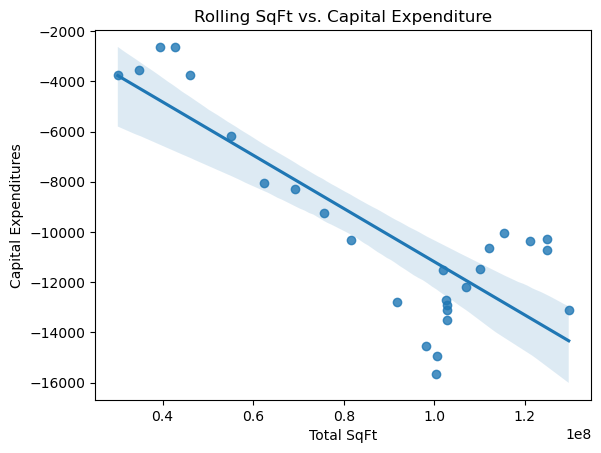

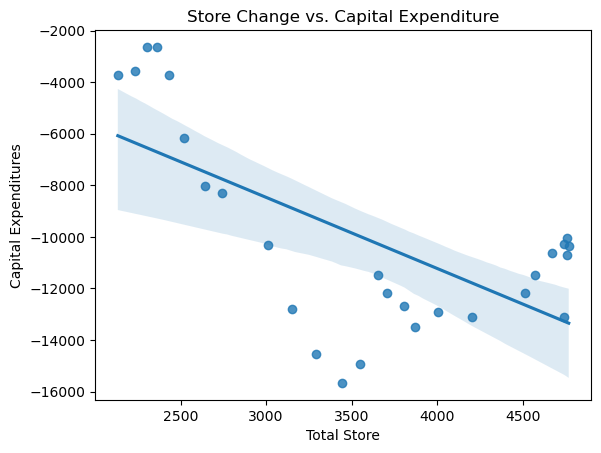

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the relationship between Capex and Rolling SqFt
sns.regplot(x='Total SqFt', y='Capital Expenditures', data=merge_data_left)
plt.title('Rolling SqFt vs. Capital Expenditure')
plt.show()

sns.regplot(x='Total Store', y='Capital Expenditures', data=merge_data_left)
plt.title('Store Change vs. Capital Expenditure')
plt.show()



In [80]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'data' is your DataFrame
# Convert all columns to numeric, setting errors='coerce' will convert non-convertible types to NaN


merge_inner_numeric = merge_data_inner.apply(pd.to_numeric, errors='coerce')
merge_left_numeric = merge_data_left.apply(pd.to_numeric, errors='coerce')

merge_left_numeric.index = pd.to_datetime(merge_left_select.index, format='%Y', errors='coerce')
merge_left_numeric.interpolate(method='linear', fill_value="extrapolate", limit_direction="both",inplace=True)
merge_left_numeric.isna().any(axis='columns')


# merge_inner_select = merge_inner_numeric[['Capital Expenditures', 'Net Income', 'Total Store', 'Total SqFt Thousands']]
merge_left_select = merge_left_numeric[['Capital Expenditures', 'Net Income', 'Total Store', 'Total SqFt Thousands']]

merge_left_select.index = pd.to_datetime(merge_left_select.index, format='%Y', errors='coerce')
merge_left_select.interpolate(method='linear', fill_value="extrapolate", limit_direction="both",inplace=True)
merge_left_select.isna().any(axis='columns')

# Check your data
merge_left_select

/var/folders/dx/h3p_55411w75zkwtmc1941gr0000gn/T/ipykernel_17873/289655422.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_left_select.interpolate(method='linear', fill_value="extrapolate", limit_direction="both",inplace=True)


,Capital Expenditures,Net Income,Total Store,Total SqFt Thousands
Year,,,,
1995-01-01,-3734.0,2681.0,2133.0,30126.089000
1996-01-01,-3566.0,2740.0,2234.0,34873.806000
1997-01-01,-2643.0,3056.0,2304.0,39493.206000
1998-01-01,-2636.0,3526.0,2362.0,42698.206000
1999-01-01,-3734.0,4430.0,2433.0,46145.837000
2000-01-01,-6183.0,5377.0,2522.0,55106.097000
2001-01-01,-8042.0,6295.0,2643.0,62426.741000
2002-01-01,-8285.0,6448.0,2744.0,69164.741000
2003-01-01,-9245.0,7818.0,2878.5,75709.759000


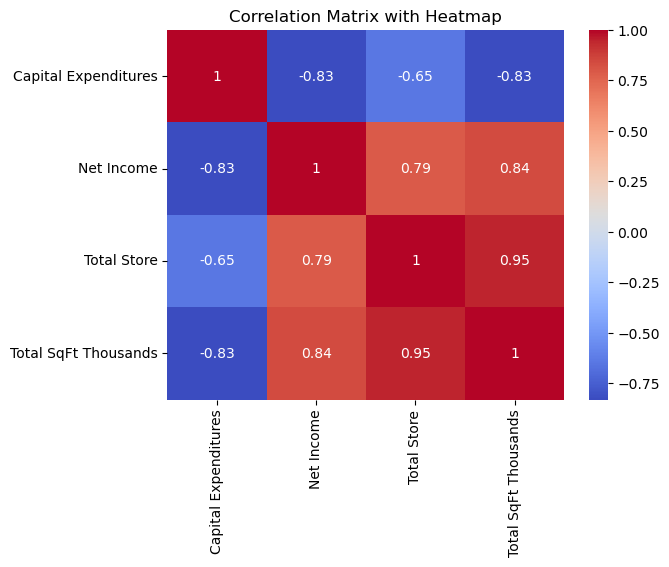

                feature         VIF
0  Capital Expenditures   37.381731
1            Net Income   22.900167
2           Total Store   93.797204
3  Total SqFt Thousands  174.963648


In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def analyze_correlations(variateDFT):
    # Creating a correlation matrix and displaying it as a heatmap
    corr_matrix = variateDFT.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix with Heatmap')
    plt.show()

    # Checking for multicollinearity using Variance Inflation Factor (VIF)
    vif_data = pd.DataFrame()
    vif_data["feature"] = variateDFT.columns
    vif_data["VIF"] = [variance_inflation_factor(variateDFT.values, i) for i in range(len(variateDFT.columns))]
    print(vif_data)


analyze_correlations(merge_left_select)   


In [84]:

# df=variateDFT
# # Assuming 'df' contains your data with columns 'Year', 'Net_Income', and 'Capex'
# X = sm.add_constant(df['Net Income'])  # Adds a constant term to the predictor
# y = df['Capital Expenditures']

# model = sm.OLS(y, X).fit()
# df['Capex_Residual'] = model.resid  # Calculate and store residuals

# # Review model summary to validate the linear relationship
# print(model.summary())

import pandas as pd
import statsmodels.api as sm

def analyze_capex_relationship(data, net_income_col, capex_col):
    # Add a constant term to the predictor for the linear regression model
    #X = sm.add_constant(data[net_income_col])
    X = data[net_income_col]
    y = data[capex_col]

    # Fit the linear regression model
    model = sm.OLS(y, X).fit()
    
    # Calculate and store residuals in the DataFrame
    data['Capex Residual '+net_income_col] = model.resid

    # Print the summary of the model to review the linear relationship
    print(model.summary())

    return data


analyze_capex_relationship(merge_left_select, 'Net Income', 'Capital Expenditures')
analyze_capex_relationship(merge_left_select, 'Total Store', 'Capital Expenditures')
analyze_capex_relationship(merge_left_select, 'Total SqFt Thousands', 'Capital Expenditures')


import pandas as pd
import statsmodels.api as sm

def perform_ols_regression(data, predictors, response):
    """
    Performs a multivariable OLS regression.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the dataset.
    - predictors (list of str): The names of the predictor columns.
    - response (str): The name of the response column.

    Returns:
    - model_summary (str): A summary of the regression model.
    """
    # Selecting predictors and adding a constant for the intercept
    X = data[predictors]
    #X = sm.add_constant(X)

    # Selecting the response variable
    y = data[response]

    # Creating and fitting the OLS model
    model = sm.OLS(y, X).fit()

    # Returning the summary of the model
    return model.summary()

perform_ols_regression(merge_left_numeric,['Net Income','Discount stores','Supercenters','Neighborhood markets','Total SqFt Thousands'], 'Capital Expenditures')
perform_ols_regression(merge_left_numeric,['Discount stores','Supercenters','Neighborhood markets','Capital Expenditures'], 'Total SqFt Thousands')

#merge_left_select[['Capital Expenditures']]

                                  OLS Regression Results                                 
Dep. Variable:     Capital Expenditures   R-squared (uncentered):                   0.947
Model:                              OLS   Adj. R-squared (uncentered):              0.945
Method:                   Least Squares   F-statistic:                              480.9
Date:                  Mon, 29 Apr 2024   Prob (F-statistic):                    9.74e-19
Time:                          20:59:13   Log-Likelihood:                         -258.48
No. Observations:                    28   AIC:                                      519.0
Df Residuals:                        27   BIC:                                      520.3
Df Model:                             1                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

/var/folders/dx/h3p_55411w75zkwtmc1941gr0000gn/T/ipykernel_17873/427373901.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Capex Residual '+net_income_col] = model.resid
/var/folders/dx/h3p_55411w75zkwtmc1941gr0000gn/T/ipykernel_17873/427373901.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Capex Residual '+net_income_col] = model.resid
/var/folders/dx/h3p_55411w75zkwtmc1941gr0000gn/T/ipykernel_17873/427373901.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Total SqFt Thousands   R-squared (uncentered):                   0.997
Model:                              OLS   Adj. R-squared (uncentered):              0.997
Method:                   Least Squares   F-statistic:                              2043.
Date:                  Mon, 29 Apr 2024   Prob (F-statistic):                    5.14e-30
Time:                          20:59:13   Log-Likelihood:                         -278.57
No. Observations:                    28   AIC:                                      565.1
Df Residuals:                        24   BIC:                                      570.5
Df Model:                             4                                                  
Covariance Type:              nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Discount stores         12.5885      1.454      8.660      0.000       9.588      15.589
Supercenters            16.2044      3.715      4.361      0.000       8.536      23.873
Neighborhood markets    26.8763      9.679      2.777      0.010       6.899      46.854
Capital Expenditures    -3.1922      0.655     -4.872      0.000      -4.545      -1.840
==============================================================================
Omnibus:                        1.680   Durbin-Watson:                   0.491
Prob(Omnibus):                  0.432   Jarque-Bera (JB):                1.509
Skew:                          -0.461   Prob(JB):                        0.470
Kurtosis:                       2.334   Cond. No.                         110.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
def analyze_capex_store_relationship(financial_data, store_counts):
    # Extracting CapEx data and the relevant years
    capex_data = financial_data[financial_data['Cash Metric'].isin(['Purchase of Fixed Assets', 'Capital Expenditures'])]
    print(f"Before transposition: {capex_data.shape}")  # Check the shape before transposition
    print(capex_data)  # View the content
    
    capex_data = capex_data.drop('Cash Metric', axis=1).transpose()  # Transpose to make the years as rows
    print(f"After transposition: {capex_data.shape}")  # Check the shape after transposition
    print(capex_data)  # View the content
    
    # Ensure that we have exactly two rows for 'Purchase of Fixed Assets' and 'Capital Expenditures'
    if capex_data.shape[0] == 2:
        capex_data.columns = ['Purchase of Fixed Assets', 'Capital Expenditures']
    else:
        raise ValueError("The CapEx data does not have the expected number of rows after transposition.")
    
    # ... rest of the original function ...
    
    return capex_data  # Temporarily return this to check the output

# Call the function with the data
capex_data_checked = analyze_capex_store_relationship(cashflow_data, store_count)


Before transposition: (2, 29)
                 Cash Metric        2022        2021        2020        2019  \
32  Purchase of Fixed Assets -13106000.0 -10264000.0 -10705000.0 -10344000.0   
35      Capital Expenditures -13106000.0 -10264000.0 -10705000.0 -10344000.0   

          2018        2017        2016        2015        2014  ...  \
32 -10051000.0 -10619000.0 -11477000.0 -12174000.0 -13115000.0  ...   
35 -10051000.0 -10619000.0 -11477000.0 -12174000.0 -13115000.0  ...   

          2004       2003       2002       2001       2000       1999  \
32 -10308000.0 -9245000.0 -8285000.0 -8042000.0 -6183000.0 -3734000.0   
35 -10308000.0 -9245000.0 -8285000.0 -8042000.0 -6183000.0 -3734000.0   

         1998       1997       1996       1995  
32 -2636000.0 -2643000.0 -3566000.0 -3734000.0  
35 -2636000.0 -2643000.0 -3566000.0 -3734000.0  

[2 rows x 29 columns]
After transposition: (28, 2)
              32          35
2022 -13106000.0 -13106000.0
2021 -10264000.0 -10264000.0
2020 -107

ValueError: The CapEx data does not have the expected number of rows after transposition.

In [22]:
import pandas as pd


def preprocess_store_counts(store_counts):
    # Ensure all data is numeric, converting non-numeric to NaN
    store_counts = store_counts.apply(pd.to_numeric, errors='coerce')

    # Calculate net change in stores per year for each type of store
    store_counts_diff = store_counts.diff(axis=1)  # Calculate year-over-year difference
    store_counts_diff = store_counts_diff.iloc[:, 1:]  # Exclude the first column as it will be NaN after diff
    
    return store_counts_diff

# Re-run the preprocessing with corrected data types
# store_counts_diff = preprocess_store_counts(store_count)

# Optionally, you can check if there are many NaNs, which might indicate many non-numeric entries
# print(store_counts_diff.isna().sum())

def correlate_capex_changes(store_counts_diff, financial_data):
    # Focus on Capital Expenditures for simplicity
    capex_data = financial_data.loc[financial_data['Cash Metric'].isin(['Capital Expenditures'])]
    capex_data = capex_data.drop('Cash Metric', axis=1).transpose()
    capex_data.columns = ['Capital Expenditures']  # Set proper column name after transpose

    # Ensure data types are correct for analysis
    capex_data = capex_data.astype(float)  # Convert CapEx data to float for calculations
    store_counts_diff = store_counts_diff.astype(float)  # Also ensure store count diffs are float

    # Align the indices of both DataFrames to ensure they match for correlation analysis
    # Both should have years as indices and be aligned accordingly
    if not capex_data.index.equals(store_counts_diff.columns):
        # Assuming both indices are years and formatted similarly
        # This step might need adjustment based on actual index formats
        capex_data = capex_data.reindex(store_counts_diff.columns)
        print(store_counts_diff)
        store_counts_diff=store_counts_diff.T
        store_counts_diff=store_counts_diff.shift(periods=-1)
        store_counts_diff=store_counts_diff.T
        print(store_counts_diff)
    # Compute correlation matrix
    correlation_matrix = pd.concat([capex_data.iloc[::-1], store_counts_diff.loc[3]], axis=1).corr()
    print(capex_data)
    return correlation_matrix

# Assuming 'cashflow_data' and 'store_count' are your DataFrames loaded correctly
store_counts_diff = preprocess_store_counts(store_count)

correlation_results = correlate_capex_changes(store_counts_diff, cashflow_data)

# Output results
print(correlation_results)
store_count_total=store_count.loc[3]

   2012   2013   2014   2015  2016  2017  2018  2019  2020  2021  ...   2005  \
0   NaN  129.0  130.0  119.0  58.0  57.0  39.0   9.0   1.0  -1.0  ... -267.0   
1   NaN   76.0  121.0  232.0  28.0  68.0  65.0  13.0  -4.0 -10.0  ...  -15.0   
2   NaN  -68.0  -53.0  -38.0 -28.0 -27.0 -15.0 -14.0 -10.0  -2.0  ...  144.0   
3   NaN  137.0  198.0  313.0  58.0  98.0  89.0   8.0 -13.0 -13.0  ... -138.0   

    2004   2002   2001   2000   1999   1998  1997   1996   1995  
0 -242.0 -405.0 -178.0 -167.0 -157.0 -123.0 -97.0 -105.0  -96.0  
1  -21.0  -33.0  -12.0    NaN    NaN    NaN   NaN    NaN    NaN  
2  125.0  169.0   89.0   65.0   68.0   52.0  39.0   35.0   -5.0  
3 -138.0 -269.0 -101.0 -121.0  -89.0  -71.0 -58.0  -70.0 -101.0  

[4 rows x 27 columns]
    2012   2013   2014  2015  2016  2017  2018  2019  2020  2021  ...   2005  \
0  129.0  130.0  119.0  58.0  57.0  39.0   9.0   1.0  -1.0   3.0  ... -242.0   
1   76.0  121.0  232.0  28.0  68.0  65.0  13.0  -4.0 -10.0   0.0  ...  -21.0   
2  -68

In [23]:

# def correlate_capex_changes(store_counts_diff, financial_data):
#     # Focus on Capital Expenditures for simplicity
capex_data = cashflow_data.loc[cashflow_data['Cash Metric'].isin(['Capital Expenditures'])]
capex_data = capex_data.drop('Cash Metric', axis=1).transpose()
capex_data.columns = ['Capital Expenditures']  # Set proper column name after transpose
capex_data.index
print(capex_data)
dist_counts_diff = preprocess_store_counts(totaldist_count.T)
dist_counts_diffT=dist_counts_diff.T
dist_counts_diffT=dist_counts_diffT.shift(periods=-5)
dist_counts_diffT.index=dist_counts_diffT.index.astype('string')
print(dist_counts_diffT)


dist_counts_diffT = dist_counts_diffT.loc[dist_counts_diffT.index.isin(capex_data.index)]
#dist_counts_diffT
correlation_matrix = pd.concat([capex_data, dist_counts_diffT], axis=1).corr()
correlation_matrix


    # # Ensure data types are correct for analysis
    # capex_data = capex_data.astype(float)  # Convert CapEx data to float for calculations
    # store_counts_diff = store_counts_diff.astype(float)  # Also ensure store count diffs are float

    # # Align the indices of both DataFrames to ensure they match for correlation analysis
    # # Both should have years as indices and be aligned accordingly
    # if not capex_data.index.equals(store_counts_diff.columns):
    #     # Assuming both indices are years and formatted similarly
    #     # This step might need adjustment based on actual index formats
    #     #capex_data = capex_data.reindex(store_counts_diff.columns)
    #     store_counts_diff=store_counts_diff.loc[store_counts['Cash Metric'].isin(['Capital Expenditures'])]
    #     store_counts_diff=store_counts_diff.reindex(capex_data.index)
    #     store_counts_diff=store_counts_diff.T
    #     #print(store_counts_diff)
    # # Compute correlation matrix
    # correlation_matrix = pd.concat([capex_data, store_counts_diff], axis=1).corr()
    # return correlation_matrix

# Assuming 'cashflow_data' and 'store_count' are your DataFrames loaded correctly

# correlation_results = correlate_capex_changes(dist_counts_diff, cashflow_data)

# Output results
#print(correlation_results)


      Capital Expenditures
2022           -13106000.0
2021           -10264000.0
2020           -10705000.0
2019           -10344000.0
2018           -10051000.0
2017           -10619000.0
2016           -11477000.0
2015           -12174000.0
2014           -13115000.0
2013           -12898000.0
2012           -13510000.0
2011           -12699000.0
2010           -12184000.0
2009           -11499000.0
2008           -14937000.0
2007           -15666000.0
2006           -14530000.0
2005           -12803000.0
2004           -10308000.0
2003            -9245000.0
2002            -8285000.0
2001            -8042000.0
2000            -6183000.0
1999            -3734000.0
1998            -2636000.0
1997            -2643000.0
1996            -3566000.0
1995            -3734000.0


NameError: name 'totaldist_count' is not defined

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def expanded_correlation_analysis(financial_data, metrics_list):
    # Filter for relevant metrics
    relevant_data = financial_data[metrics_list]
    # Calculate correlations
    correlation_matrix = relevant_data.corr()
    
    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix for Financial Metrics')
    plt.show()

    return correlation_matrix

# Define the list of metrics to include in the analysis
metrics_to_analyze = [
    'Capital Expenditures',
    'Net Income',
    'Total Cash from Operating Activities',
    'Depreciation',
    'Changes in Working Capital',
    'Total Cash from Financing Activities'
]

if cashflow_data.index.name != 'Cash Metric':
    cashflow_datacopy=cashflow_data.copy
    cashflow_data.set_index('Cash Metric', inplace=True)  # Setting 'Cash Metric' as index

cashflow_dataT=cashflow_data.T
cashflow_dataT.columns
# cashflow_dataT['Net Income']

# Assuming 'cashflow_data' is your DataFrame containing all financial metrics
correlation_results = expanded_correlation_analysis(cashflow_dataT, metrics_to_analyze)
print(correlation_results)



In [ ]:

def analyze_capex_store_relationship(financial_data, store_counts):
    # Analyze the relationship between CapEx and store counts
    # ...

def model_capex_for_new_stores(financial_data, store_counts):
    # Model CapEx for new stores using regression analysis or curve fitting
    # ...

def monte_carlo_simulation(model):
    # Perform Monte Carlo simulation using the CapEx model
    # ...

def integrate_with_expansion_model(expansion_model, capex_model):
    # Update NeighborhoodMarketExpansionModel with new CapEx estimates
    # ...

# Now let's run these functions in sequence

preprocessed_financial_data = preprocess_data(financial_data, store_counts)
capex_store_relationship = analyze_capex_store_relationship(preprocessed_financial_data, store_counts)
capex_model = model_capex_for_new_stores(preprocessed_financial_data, store_counts)
simulation_results = monte_carlo_simulation(capex_model)
integrate_with_expansion_model(neighborhood_market_expansion_model, capex_model)


## Distribution Center Correlation

In [ ]:
import pandas as pd

# Assuming 'distribution_center_data' is loaded into a DataFrame with a 'Total' column already calculated
def preprocess_distribution_totals(distribution_center_data):
    # Calculate year-over-year changes for the total count of distribution centers
    distribution_diff = distribution_center_data['Total'].diff().dropna()  # Calculate and drop the first NaN result
    return distribution_diff

def correlate_distribution_totals_capex(distribution_diff, capex_data):
    # Ensure capex_data is aligned and formatted correctly, focusing on 'Capital Expenditures'
    capex_data = capex_data.loc[capex_data['Cash Metric'] == 'Capital Expenditures'].drop('Cash Metric', axis=1)
    capex_data = capex_data.transpose()
    capex_data.columns = ['CapEx']
    
    # Ensure the years align between both datasets
    common_years = distribution_diff.index.intersection(capex_data.index)
    distribution_aligned = distribution_diff.loc[common_years]
    capex_aligned = capex_data.loc[common_years]
    
    # Compute correlation
    correlation_result = distribution_aligned.corr(capex_aligned['CapEx'])
    return correlation_result

# Load your distribution center data and cash flow data correctly before calling these functions
distribution_diff = preprocess_distribution_totals(distribution_center_data)
correlation_result = correlate_distribution_totals_capex(distribution_diff, cashflow_data)

# Print or visualize the result
print("Correlation between total distribution center changes and CapEx:", correlation_result)


## Some Visual Trash

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import stats
# from sklearn.linear_model import LinearRegression

# # Analyzing the relationship between CapEx and store counts
# def analyze_capex_store_relationship(financial_data, store_counts):
#     # Here you can calculate correlations and perform regression analysis
#     # This is a placeholder for the real implementation
#     correlation = financial_data.corrwith(store_counts)
#     print("Correlation between CapEx and store counts:", correlation)
    
#     # For visualization, you could plot CapEx vs store counts
#     plt.scatter(store_counts, financial_data['Capital Expenditures'])
#     plt.xlabel('Store Counts')
#     plt.ylabel('Capital Expenditures')
#     plt.show()

# # Modeling CapEx for new stores using regression analysis
# def model_capex_for_new_stores(financial_data, store_counts):
#     # Prepare the data
#     X = store_counts.values.reshape(-1, 1)  # Features
#     y = financial_data['Capital Expenditures'].values      # Target variable
    
#     # Fit the linear regression model
#     model = LinearRegression()
#     model.fit(X, y)
    
#     return model

# # Performing Monte Carlo simulation using the CapEx model
# def monte_carlo_simulation(model, n_simulations=1000):
#     # Placeholder for real implementation
#     # Simulate different scenarios to project future CapEx
#     simulations = []
#     for _ in range(n_simulations):
#         simulated_store_count = np.random.normal(loc=store_count_mean, scale=store_count_std)
#         projected_capex = model.predict([[simulated_store_count]])
#         simulations.append(projected_capex)
    
#     return np.mean(simulations), np.std(simulations)

# # Assuming financial_data and store_counts DataFrames are already preprocessed and loaded
# capex_model = model_capex_for_new_stores(cashflow_data, store_count)
# mean_projection, std_deviation = monte_carlo_simulation(capex_model)
# print(f"Projected CapEx Mean: {mean_projection}, Standard Deviation: {std_deviation}")
